<h1 align=center> Text classification using word embedding and feed forward networks</h1>

In this project we try to perfom the task of text classification, using GloVe word embedding module and classic feed forward neural network. Text classification is a machine learning technique that assigns a set of predefined categories to open-ended text. We will use the <i>HappyDB</i> dataset. HappyDB is a corpus of 100,000 crowd-sourced happy moments gathered by Megagon Labs. <a href="https://megagon.ai/happydb-a-happiness-database-of-100000-happy-moments/#:~:text=What%20is%20Happy%20DB%3F,can%20be%20gleaned%20from%20text.">Click too see website.</a>
<br>

<h3>Imports</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from torchtext.vocab import GloVe
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from sklearn.metrics import classification_report, confusion_matrix


<h3>1. Reading and exploring data</h3>

In the cells below, we will read and analyse the dataset.

In [2]:
HappyDB = pd.read_csv("./cleaned_hm.csv")
HappyDB.head(4)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding


This dataset consist of 100535 rows and 9 columns. We will try to predict the <i>predicted_category</i> column, 
using <i>cleaned_hm</i> column. The reason that we dont use the <i>ground_truth_category</i> as target variable is that as is can be seen from the below cell, it contains a lot of missing values.

In [3]:
HappyDB['ground_truth_category'].isnull().sum()

86410

<h4>Plot target variable histogram</h4>

Now we will try to extract our target values and their count in the dataset. As it can be seen, there are 7 target categories and they are completely imbalanced in count.

<AxesSubplot:>

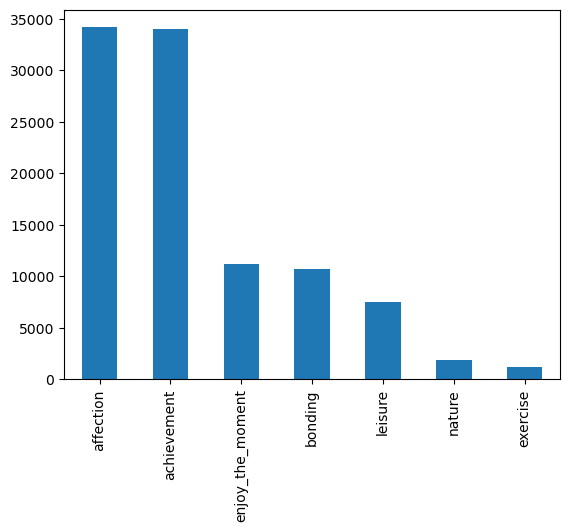

In [4]:
HappyDB['predicted_category'].value_counts().plot(kind='bar')

<h4>Drop data with more than 5 sentences</h4>

Now we will consider the <i>num_sentence</i> column. As the histogram suggests, there are a little happy moments with more than 5 sentences. We can drop the rows with more than 5 sentences so we won't deal with very long inputs.

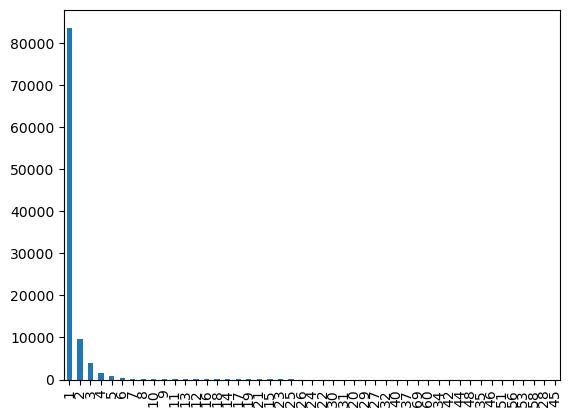

In [5]:
HappyDB['num_sentence'].value_counts().plot(kind='bar')

HappyDB.drop(HappyDB[(HappyDB['num_sentence'] > 5 )].index, inplace=True)

<h4>Encode target variable</h4>

The target variable consists of categorical data which can not be helpful to our model. So we encode the categorical values with numerical ones. It can be seen that the target value is not integer encoded.

In [6]:
HappyDB['predicted_category'] = HappyDB['predicted_category'].astype('category')
HappyDB['predicted_category'] = HappyDB['predicted_category'].cat.codes

HappyDB.head(4)

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,1
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,1
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,4
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,2


<h3>2. Preprocessing</h3>

Before we obtain X and y values ready to be fed to a model, we have to do some preprocessing on data. Especially on the features, because it contains text values that can not be fed to model directly.
<br>

<h4>Tokenizing</h4>
First of all, we have to tokenize the texts. So we will deal with words, rather can sentences.

In [7]:
def tokenize(string):
    
    return word_tokenize(string)

<h4>Padding</h4>
Then we will have to perfom padding on the tokenized sentences. This means they should all have the same length. Here we will define a maximum length for texts, then we will proceed to pad texts shorter with empty string to meet the required length. And with the case of texts longer than that limit, we will simply just consider the first portion of them.

In [8]:
max_words = 50

In [9]:
def pad(tokenized_string, max_length = 50):
    
    if len(tokenized_string) < max_length:        
        tokenized_string += [""] * (max_length - len(tokenized_string))
        
    elif len(tokenized_string) > max_length:
        tokenized_string = tokenized_string[:max_length]
        
    return tokenized_string

In [10]:
def preprocess(dataframe):
    
    X = []
    happymoments = dataframe["cleaned_hm"].values.tolist()
    
    for document in happymoments:
        
        document = document.lower()
        document = tokenize(document)
        document = pad(document, max_words)
        X.append(document)
        
    return np.array(X)

That is all for preprocessing here. Now we can get the processed text. And we can also get the target values. By printing $X$ and $y$'s shape, we can see that we have 99545 padded strings in X, each containing 50 words, and we also have 99545 target values.

In [11]:
X = preprocess(HappyDB)
y = np.array(HappyDB['predicted_category'].values)

print(X.shape)
print(y.shape)

(99545, 50)
(99545,)


<h3>3. Train-Test split and building DataLoaders</h3>

Now that we have $X$ and $y$, we can split them ro train and text, and we can build the DataLoaders.

<h4>Train Test Split</h4>

Here we will just use <i>train_test_split</i> function from <i>sklearn</i>. Then we will zip target values with tokenized texts, so they will be ready to be provided as input for DataLoaders.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

train_data = np.array(list(zip(X_train, y_train)), dtype=object)
val_data   = np.array(list(zip(X_val, y_val)), dtype=object)

<h4>Word embedding</h4>

We have $X$ array which contains of set of tokenized words. But we still can not provide them as inputs for models because models are good at working only with numerical data. So we will have to vectorize each word in our $X$ set before we can feed them to the model. Here we will use GloVe word embedding module to vectorize each word.

In [13]:
GloVe = GloVe(name='840B', dim=300)
embed_len = 300

In [14]:
def vectorize(batch):
    X, y = list(zip(*batch))
        
    X_tensor = torch.zeros(len(batch), max_words, embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = GloVe.get_vecs_by_tokens(list(tokens))
    return X_tensor.reshape(len(batch), -1), torch.tensor(y, dtype=torch.long)

<h4>Making DataLoader</h4>
Now we are ready to build the DataLoaders, which will contain training and validating data sets.

In [15]:
batch_size = 128

train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=vectorize)
val_loader   = DataLoader(val_data,   batch_size=batch_size,  collate_fn=vectorize)

We can see that we have 15000 features, that is 300 features for 50 words in each string.

In [16]:
for batch, (X, y) in enumerate(train_loader):
    print(X.shape)
    print(y.shape)
    break

torch.Size([128, 15000])
torch.Size([128])


<h3>4. Defining model</h3>
We are ready to define our model. Our defined model here will be a classic feed forward model with 4 layers ReLU activations.

In [17]:
class ClassicMLP(nn.Module):
    def __init__(self):
        
        super(ClassicMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(max_words*embed_len, 256),
            nn.ReLU(),

            nn.Linear(256,128),
            nn.ReLU(),

            nn.Linear(128,64),
            nn.ReLU(),

            nn.Linear(64, 7),
        )

    def forward(self, X):
        return self.layers(X)

<h4>Defining Hyperparameters, loss function and optimizer</h4>

In [18]:
n_epochs = 5
learning_rate = 1e-3

classic_model = ClassicMLP()
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(classic_model.parameters(), lr=learning_rate)



<h3>5. Training the model</h3>

<h4>Train Function of model</h4>

In [19]:
def Train(model, loss_fn, train_loader, optimizer):
    
    losses = []
    
    for batch, (X, y) in enumerate(train_loader):
        
        y_probs = model(X)
        loss = loss_fn(y_probs, y)
        
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    loss = torch.tensor(losses).mean().item()
    print(f"train loss {loss:.3f}")
    return loss

<h4>Validation Function of model</h4>

In [20]:
def Validate(model, loss_fn, test_loader):
    
    losses = []
    accurates = 0
    n_samples = 0
    
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(test_loader):
                        
            y_probs = model(X)
            loss = loss_fn(y_probs, y)
            
            losses.append(loss.item())
            
            y_preds = y_probs.argmax(dim=-1)
            
            accurates += (y == y_preds).sum()
            n_samples += y.shape[0]
        
        loss = torch.tensor(losses).mean().item()
        accuracy = 100 * accurates / n_samples
        
        print(f"validation loss: {loss:.3f}")
        print(f"validation accuracy: {accuracy :.3f}%")
        
        return loss, accuracy

<h4>Training loop</h4>

In [21]:
tr_losses = []
vl_losses = []
accuracies = []

for i in range(n_epochs):
    
    print(f"epoch {i+1}")
    
    tr_loss = Train(classic_model, loss_fn, train_loader, optimizer)
    tr_losses.append(tr_loss)
    
    vl_loss, acc = Validate(classic_model, loss_fn, val_loader)
    vl_losses.append(vl_loss)
    accuracies.append(acc)
    
    print(f"+----------------------+")

epoch 1
train loss 0.646
validation loss: 0.518
validation accuracy: 81.536%
+----------------------+
epoch 2
train loss 0.373
validation loss: 0.536
validation accuracy: 82.289%
+----------------------+
epoch 3
train loss 0.252
validation loss: 0.636
validation accuracy: 81.215%
+----------------------+
epoch 4
train loss 0.185
validation loss: 0.732
validation accuracy: 80.607%
+----------------------+
epoch 5
train loss 0.139
validation loss: 0.932
validation accuracy: 79.678%
+----------------------+


<h3>6. Evaluating Model</h3>

We will evaluate the model with plotting its train and validation loss curves. It can be seen that the model started to overfit even with small number of epochs. And the accuracy is not progressing either. It is worth mentioning that with the great imbalance of data that we saw earlier, the accuracy of 80% is not a very good result. These are because the simple feed forward model is not a great model for nlp task.

<h4>Plotting train and validation losses</h4>

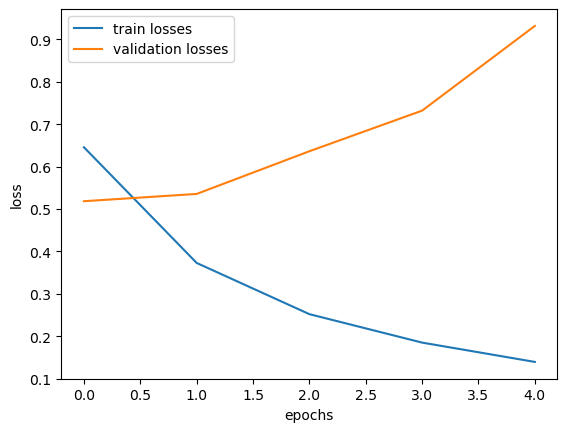

In [22]:
plt.plot(tr_losses, label="train losses")
plt.plot(vl_losses, label="validation losses")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

<h4>Plotting accuracy</h4>

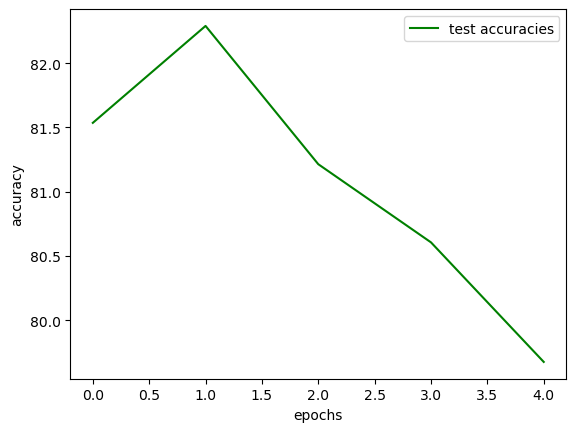

In [23]:
plt.plot(accuracies, label="test accuracies", c='g')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()